# 13 Models With Memory

## Imports, loadings and functions

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
# from causalgraphicalmodels import CausalGraphicalModel  # Just work in < python3.9 

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

In [5]:
# Utils functions

def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

## 13.1 Example: Multilevel tadpoles

### R Code 13.1

In [6]:
df = pd.read_csv('./data/reedfrogs.csv', sep=";")
df['tank'] = df.index.to_list()
df['tank'] += 1  # index start from 1 like Stan works
df

,density,pred,size,surv,propsurv,tank
0,10,no,big,9,0.900000,1
1,10,no,big,10,1.000000,2
2,10,no,big,7,0.700000,3
3,10,no,big,10,1.000000,4
4,10,no,small,9,0.900000,5
5,10,no,small,9,0.900000,6
6,10,no,small,10,1.000000,7
7,10,no,small,9,0.900000,8
8,10,pred,big,4,0.400000,9
9,10,pred,big,9,0.900000,10


In [7]:
df.describe()

,density,surv,propsurv,tank
count,48.000000,48.000000,48.000000,48.00
mean,23.333333,16.312500,0.721607,24.50
std,10.382746,9.884775,0.266416,14.00
min,10.000000,4.000000,0.114286,1.00
25%,10.000000,9.000000,0.496429,12.75
50%,25.000000,12.500000,0.885714,24.50
75%,35.000000,23.000000,0.920000,36.25
max,35.000000,35.000000,1.000000,48.00


### R Code 13.2

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{TANK[i]} $$

$$ \alpha_j \sim Normal(0, 1.5), \mbox{ for } j \in \{1, 48\}$$

In [8]:
model = """
    data {
        int qty;
        array[qty] int N;  // Total quantities that have tadpoles in tank
        array[qty] int survival;  // How many tadpoles survival
        array[qty] int tank;  // Tank index
    }
    
    parameters {
        vector[qty] alpha;
    }
    
    model {
        vector[qty] p;
        
        alpha ~ normal(0, 1.5);
        
        for (i in 1:qty){
            p[i] = alpha[ tank[i] ];
            p[i] = inv_logit(alpha[i]);
        }
        
        survival ~ binomial(N, p);
        
    }
"""

dat_list = {
    'qty': len(df),
    'tank': df['tank'].to_list(),
    'survival': df['surv'].to_list(),
    'N': df['density'].to_list()
}


posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


In [9]:
model_13_1 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [10]:
az.summary(model_13_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.711,0.777,0.546,2.984,0.011,0.009,5295.0,2572.0,1.00
alpha[1],2.385,0.879,0.967,3.717,0.012,0.010,5260.0,2560.0,1.00
alpha[2],0.755,0.651,-0.276,1.812,0.009,0.008,5567.0,3092.0,1.00
alpha[3],2.389,0.903,0.930,3.754,0.013,0.011,5197.0,2428.0,1.00
alpha[4],1.732,0.784,0.506,2.949,0.012,0.010,4688.0,2597.0,1.00
alpha[5],1.720,0.768,0.502,2.956,0.011,0.009,4803.0,3138.0,1.00
alpha[6],2.421,0.921,0.937,3.855,0.013,0.011,5013.0,2478.0,1.00
alpha[7],1.729,0.761,0.502,2.943,0.011,0.009,4747.0,2652.0,1.00
alpha[8],-0.360,0.592,-1.265,0.631,0.008,0.008,5362.0,2939.0,1.00
alpha[9],1.711,0.764,0.503,2.911,0.011,0.010,4955.0,2448.0,1.00


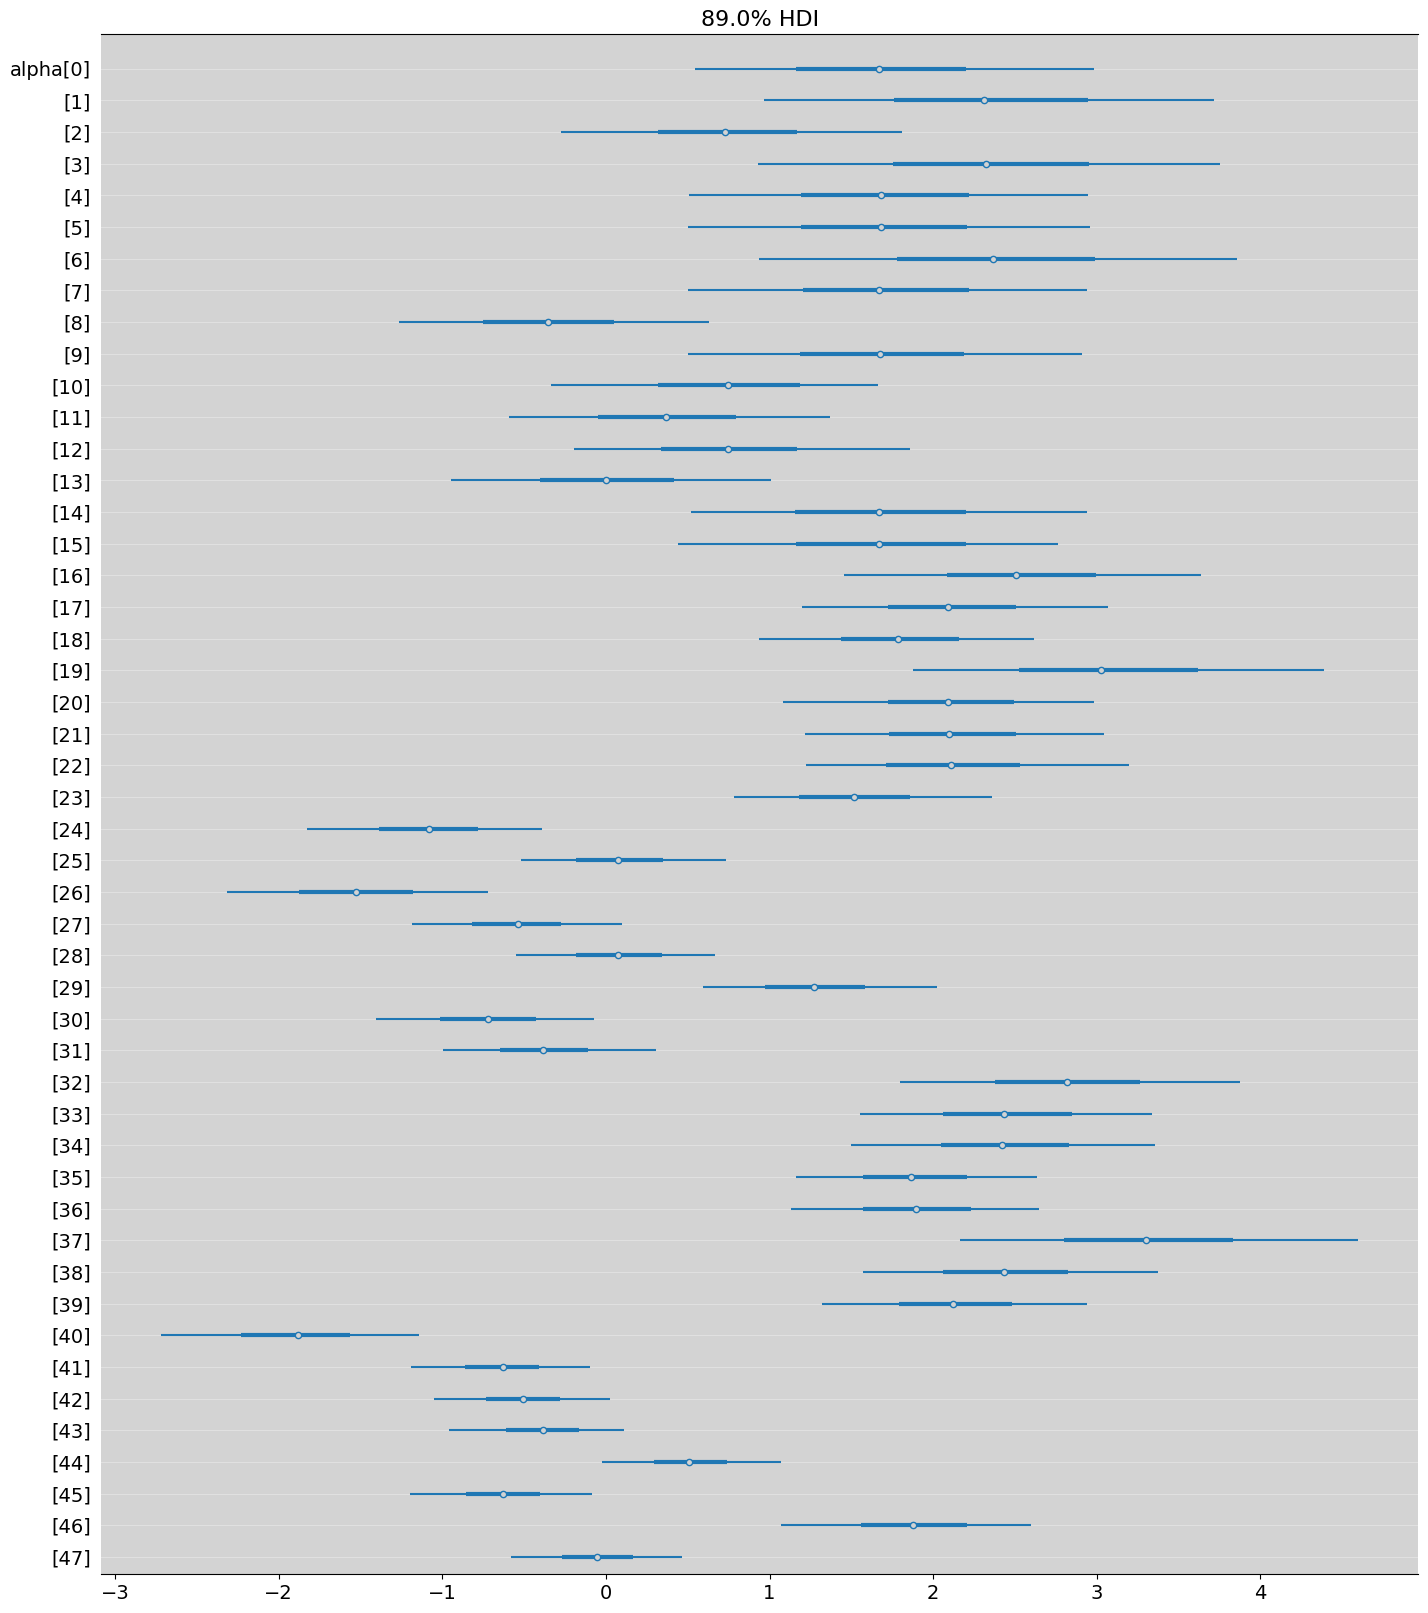

In [11]:
az.plot_forest(model_13_1, hdi_prob=0.89, combined=True, figsize=(17, 20))

plt.grid(axis='y', c='white', alpha=0.3)
plt.show()

### R Code 13.3

#### Multilevel model Tadpole

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{TANK[i]} $$

$$ \alpha[j] \sim Normal(\bar{\alpha}, \sigma) \mbox{ - [Adaptative prior]} $$

$$ \bar{\alpha} \sim Normal(0, 1.5) \mbox{ - [prior to average tank]} $$

$$ \sigma \sim Exponential(1) \mbox{ - [prior for standard deviation of tanks]} $$

In [12]:
model = """
    data {
        int qty;
        array[qty] int N;
        array[qty] int survival;
        array[qty] int tank;
    }
    
    parameters {
        vector[qty] alpha;
        real bar_alpha;
        real<lower=0> sigma;
    }
    
    model {
        vector[qty] p;
        
        alpha ~ normal(bar_alpha, sigma);
        
        bar_alpha ~ normal(0, 1.5);
        sigma ~ exponential(1);
        
        for (i in 1:qty){
            p[i] = alpha[ tank[i] ];
            p[i] = inv_logit(p[i]);
        }
    
        survival ~ binomial(N, p);
    }
"""


dat_list = {
    'qty': len(df),
    'tank': df['tank'].to_list(),
    'survival': df['surv'].to_list(),
    'N': df['density'].to_list()
}


posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!


In [13]:
model_13_2 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys(),
)

In [14]:
az.summary(model_13_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.145,0.872,0.834,3.581,0.014,0.011,4569.0,2424.0,1.0
alpha[1],3.095,1.141,1.174,4.788,0.019,0.015,4210.0,2668.0,1.0
alpha[2],1.009,0.681,-0.095,2.048,0.011,0.009,3910.0,2591.0,1.0
alpha[3],3.103,1.145,1.274,4.770,0.020,0.015,3897.0,2474.0,1.0
alpha[4],2.166,0.904,0.721,3.517,0.015,0.013,4160.0,2184.0,1.0
alpha[5],2.133,0.872,0.714,3.431,0.014,0.012,4145.0,2518.0,1.0
alpha[6],3.080,1.148,1.299,4.837,0.021,0.017,3770.0,2009.0,1.0
alpha[7],2.144,0.902,0.773,3.516,0.013,0.011,5278.0,2785.0,1.0
alpha[8],-0.177,0.608,-1.095,0.871,0.009,0.009,5063.0,3142.0,1.0
alpha[9],2.141,0.868,0.685,3.405,0.013,0.010,5228.0,2830.0,1.0


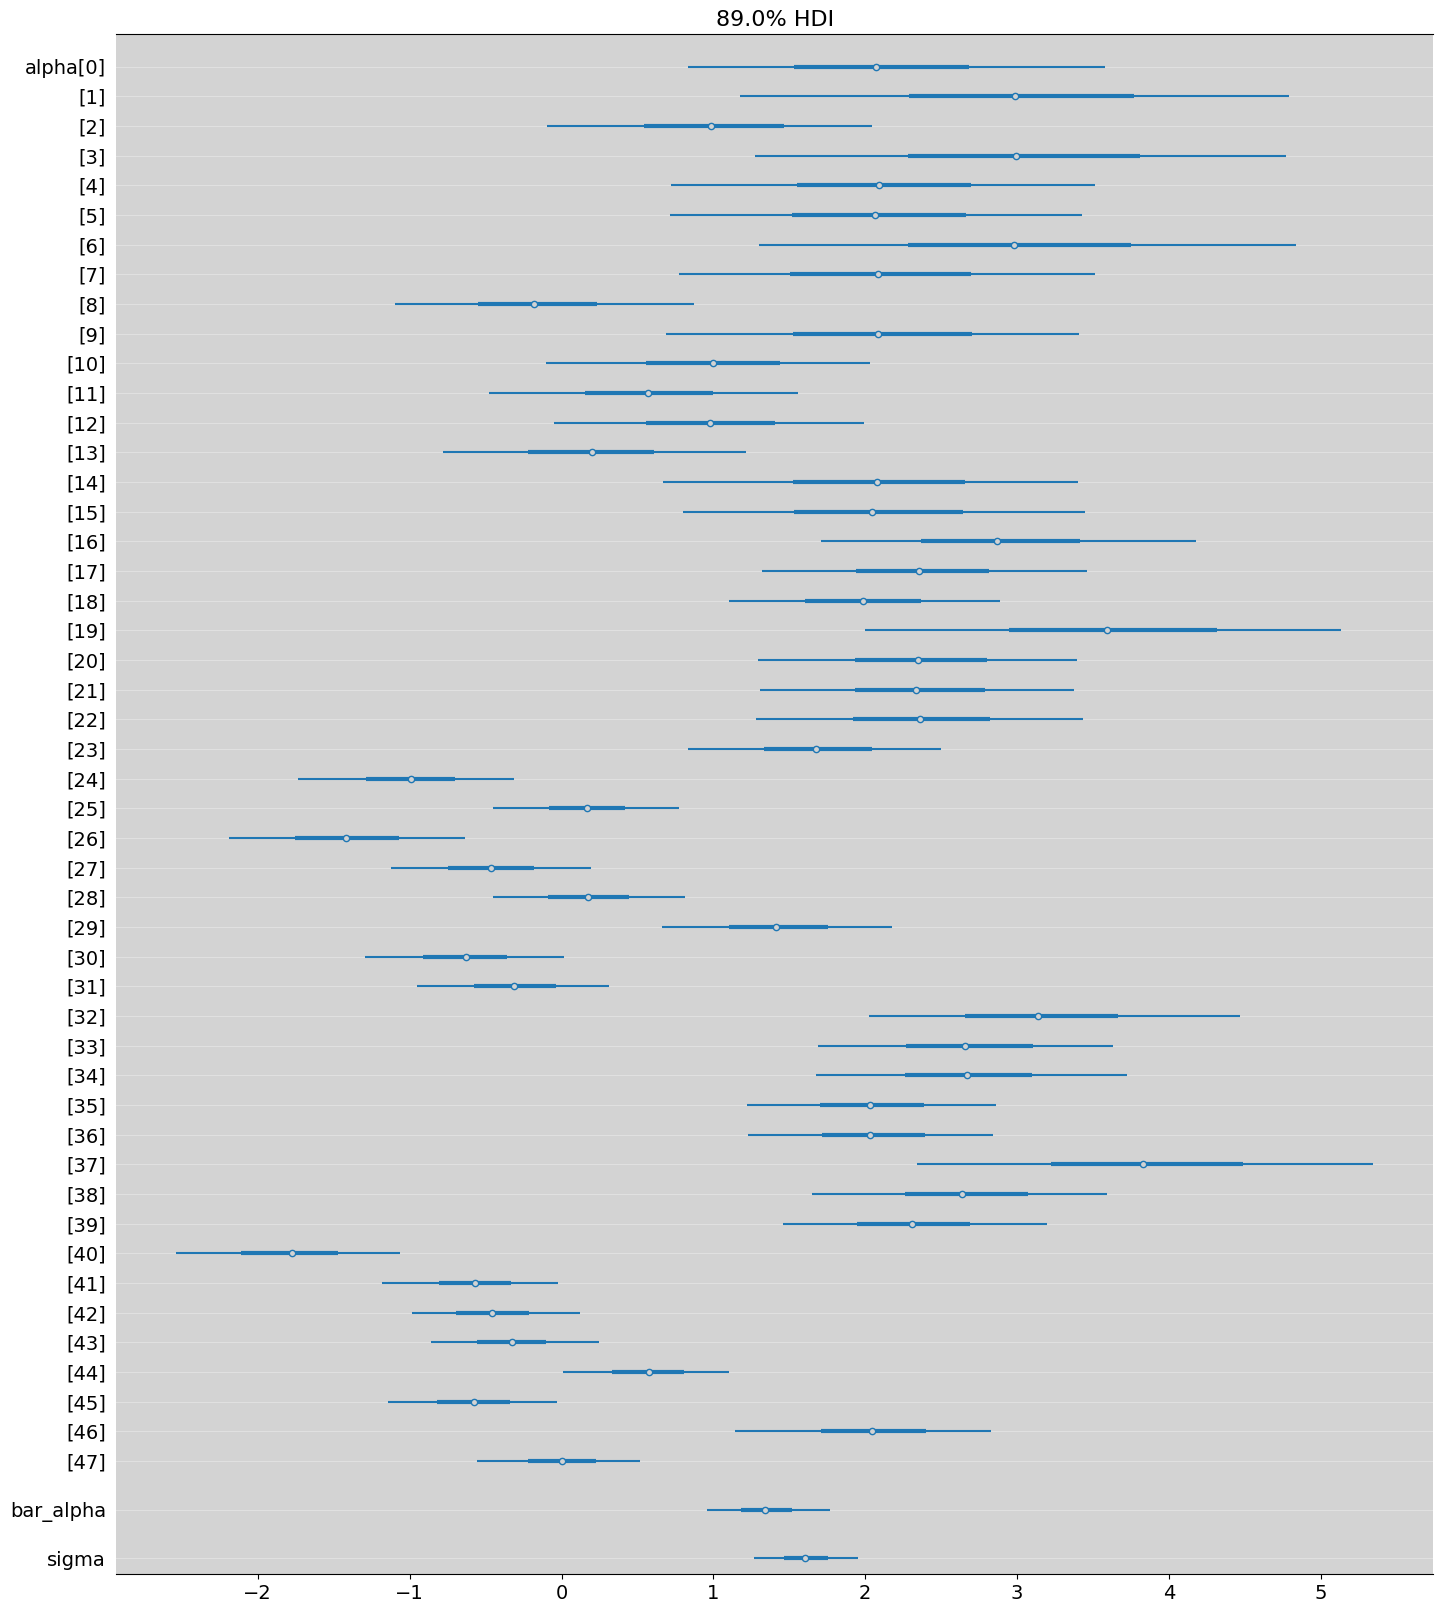

In [15]:
az.plot_forest(model_13_2, hdi_prob=0.89, combined=True, figsize=(17, 20))

plt.grid(axis='y', color='white', alpha=0.3)
plt.show()

### R Code 13.4

In [16]:
# az.compare(model_13_1, model_13_2)

### R Code 13.5

In [17]:
means = [ model_13_2.posterior.alpha.sel(alpha_dim_0=(i-1)).values.flatten().mean() for i in df.tank ]
means = inv_logit(means)

In [18]:
# My test, this is not originaly in book
means_13_1 = [ model_13_1.posterior.alpha.sel(alpha_dim_0=(i-1)).values.flatten().mean() for i in df.tank ]
means_13_1 = inv_logit(means_13_1)

In [19]:
bar_alpha_log = model_13_2.posterior.bar_alpha.values.flatten()
bar_alpha = inv_logit(bar_alpha_log)
bar_alpha_mean = bar_alpha.mean() 

sigma_log = model_13_2.posterior.sigma.values.flatten()
sigma = inv_logit(sigma_log)
sigma_mean = sigma.mean()

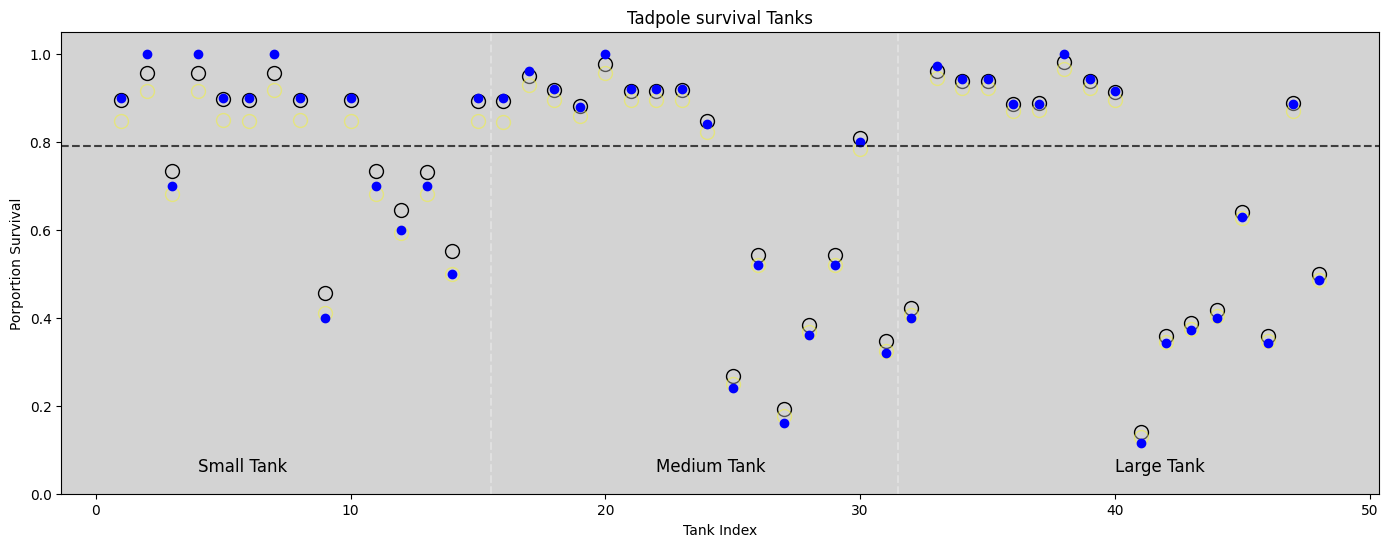

In [20]:
plt.figure(figsize=(17, 6))
plt.ylim = ([0, 1])

plt.scatter(df.tank, means, edgecolors='black', c='lightgray', s=100)
plt.scatter(df.tank, means_13_1, edgecolors='yellow', c='lightgray', s=100, alpha=0.4)
plt.scatter(df.tank, df.propsurv, c='blue')


plt.axvline(x=15.5, ls='--', color='white', alpha=0.3)
plt.axvline(x=31.5, ls='--', color='white', alpha=0.3)

plt.axhline(y=bar_alpha_mean, ls='--', c='black', alpha=0.7)

plt.text(4, 0.05, 'Small Tank', size=12)
plt.text(22, 0.05, 'Medium Tank', size=12)
plt.text(40, 0.05, 'Large Tank', size=12)

plt.gca().set_ylim(0.0, 1.05)

plt.title('Tadpole survival Tanks')
plt.xlabel('Tank Index')
plt.ylabel('Porportion Survival')

plt.show()

- **Blue dot**: Proportion survival s_i/N_i

- **Black circle**: Multilevel model estimative

- **Light Yellow**: No-pooling estimative

### R Code 13.6

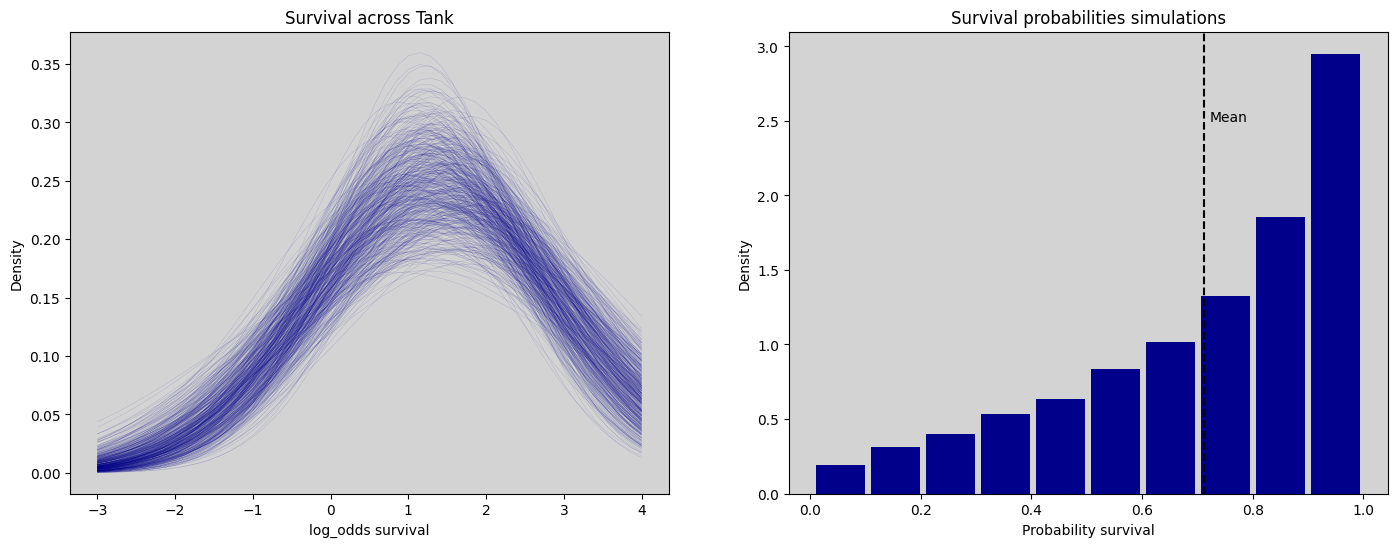

In [21]:
fig = plt.figure(figsize=(17, 6))
gs = GridSpec(1, 2)

x = np.linspace(-3, 4)

s_sampled = 500

ax1 = fig.add_subplot(gs[0, 0])
log_odds_survival = []
log_odds_sampled_index = np.random.choice(len(bar_alpha_log) ,size=s_sampled, replace=False)

for i in log_odds_sampled_index:
    log_odds_survival.append(stats.norm.pdf(x, bar_alpha_log[i], sigma_log[i]))

for i in range(s_sampled):
    ax1.plot(x, log_odds_survival[i], c='darkblue', linewidth=0.05)
ax1.set_title('Survival across Tank')
ax1.set_xlabel('log_odds survival')
ax1.set_ylabel('Density')
    

ax2 = fig.add_subplot(gs[0, 1])
samples_log = np.random.normal(bar_alpha_log, sigma_log)
ax2.hist(inv_logit(samples_log), rwidth=0.9, color='darkblue', density=True)
ax2.axvline(x=np.mean(inv_logit(samples_log)), c='black', ls='--')
ax2.text(np.mean(inv_logit(samples_log))+0.01, 2.5, 'Mean')

ax2.set_title('Survival probabilities simulations')
ax2.set_xlabel('Probability survival')
ax2.set_ylabel('Density')

plt.show()

## 13.2 Varing effects  and underfitting/overfitting trade-off

The model

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{POND[i]} $$

$$ \alpha_j \sim Normal(\bar{\alpha}, \sigma) $$

$$ \bar{\alpha} \sim Normal(0, 1.5) $$

$$ \sigma \sim Exponential(1) $$

$\bar{\alpha} := $ the avegare log-oods fo survival in the entire population of ponds

$\sigma := $ the standard deviation of the distribution of log-oods of survivial among ponds

$\alpha := $ a vector of individual pond intercepts, one for each pond

### R Code 13.7

In [125]:
a_bar = 1.5
sigma = 1.5
nponds = 60

repeats = 15

Ni = np.repeat([5, 10, 25, 35], repeats=repeats)

### R Code 13.8

In [126]:
a_pond = np.random.normal(loc=a_bar, scale=sigma, size=nponds)

### R Code 13.9

In [127]:
d = {
    'pond': np.arange(nponds) + 1,
    'Ni':Ni,
    'true_a': a_pond,
}

dsim = pd.DataFrame(data=d)
dsim.head()

,pond,Ni,true_a
0,1,5,0.994306
1,2,5,2.779161
2,3,5,2.681777
3,4,5,2.723293
4,5,5,-1.747955


### R Code 13.10

In [89]:
# Code in R -> integer vs numeric

### R Code 13.11

In [128]:
dsim['Si'] = np.random.binomial(n=dsim['Ni'], p=inv_logit(dsim['true_a']))
dsim.head()

,pond,Ni,true_a,Si
0,1,5,0.994306,5
1,2,5,2.779161,5
2,3,5,2.681777,4
3,4,5,2.723293,5
4,5,5,-1.747955,0


### R Code 13.12

#### 13.2.4 Compute the no-pooling estimates

In [129]:
dsim['p_nopool'] = dsim['Si'] / dsim['Ni']
dsim.head()

,pond,Ni,true_a,Si,p_nopool
0,1,5,0.994306,5,1.0
1,2,5,2.779161,5,1.0
2,3,5,2.681777,4,0.8
3,4,5,2.723293,5,1.0
4,5,5,-1.747955,0,0.0


### R Code 13.13

#### 13.2.5 Compute the partial-pooling estimates

In [130]:
model = """
    data {
        int N;
        array[N] int pond;  // Pond index
        array[N] int Ni;  // Population in pond[i]
        array[N] int Si;  // Survivals from Ni pond
    }
    
    parameters {
        vector[N] alpha;
        real bar_alpha;
        real<lower=0> sigma;
    }
    
    model {
        vector[N] pi;
        
        // Link
            for (i in 1:N) {
                pi[i] = alpha[ pond[i] ];
                pi[i] = inv_logit(pi[i]);
            }
        
        // Prior
        alpha ~ normal(bar_alpha, sigma);
        
        // Hyper Prior
        bar_alpha ~ normal(0, 1.5);
        sigma ~ exponential(1);
    
        // Likelihood
        Si ~ binomial(Ni, pi);
    }
"""


dat_list = {
    'N': len(dsim),
    'Ni': dsim['Ni'].to_list(),
    'pond': dsim['pond'].to_list(),
    'Si': dsim['Si'].to_list(),
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


### R Code 13.14

In [131]:
model_13_3 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list
)

In [132]:
az.summary(model_13_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.290,0.994,0.749,3.826,0.015,0.013,4688.0,2435.0,1.0
alpha[1],2.282,0.974,0.636,3.709,0.015,0.013,4667.0,2408.0,1.0
alpha[2],1.481,0.841,0.214,2.879,0.012,0.010,5360.0,3036.0,1.0
alpha[3],2.287,0.966,0.562,3.648,0.014,0.011,4961.0,2750.0,1.0
alpha[4],-0.913,0.852,-2.409,0.322,0.014,0.011,3962.0,3094.0,1.0
...,...,...,...,...,...,...,...,...,...
alpha[57],2.265,0.520,1.458,3.092,0.008,0.006,5150.0,2630.0,1.0
alpha[58],2.551,0.585,1.649,3.468,0.008,0.006,5264.0,2742.0,1.0
alpha[59],0.987,0.370,0.383,1.554,0.005,0.004,5418.0,2598.0,1.0
bar_alpha,1.384,0.184,1.088,1.673,0.003,0.002,3442.0,3045.0,1.0


### R Code 13.15

In [133]:
dsim['p_partpool'] = [inv_logit(model_13_3.posterior.alpha.sel(alpha_dim_0=i).values.mean()) for i in range(len(dsim))]
dsim.head()

,pond,Ni,true_a,Si,p_nopool,p_partpool
0,1,5,0.994306,5,1.0,0.908086
1,2,5,2.779161,5,1.0,0.907344
2,3,5,2.681777,4,0.8,0.814784
3,4,5,2.723293,5,1.0,0.907784
4,5,5,-1.747955,0,0.0,0.286385


### R Code 13.16

In [134]:
dsim['p_true'] = inv_logit(dsim['true_a'])
dsim.head()

,pond,Ni,true_a,Si,p_nopool,p_partpool,p_true
0,1,5,0.994306,5,1.0,0.908086,0.729938
1,2,5,2.779161,5,1.0,0.907344,0.941539
2,3,5,2.681777,4,0.8,0.814784,0.935943
3,4,5,2.723293,5,1.0,0.907784,0.938387
4,5,5,-1.747955,0,0.0,0.286385,0.148305


### R Code 13.17

In [135]:
no_pool_error = np.abs(dsim['p_nopool'] - dsim['p_true'])
partpool_error = np.abs(dsim['p_partpool'] - dsim['p_true'])

### R Code 13.18

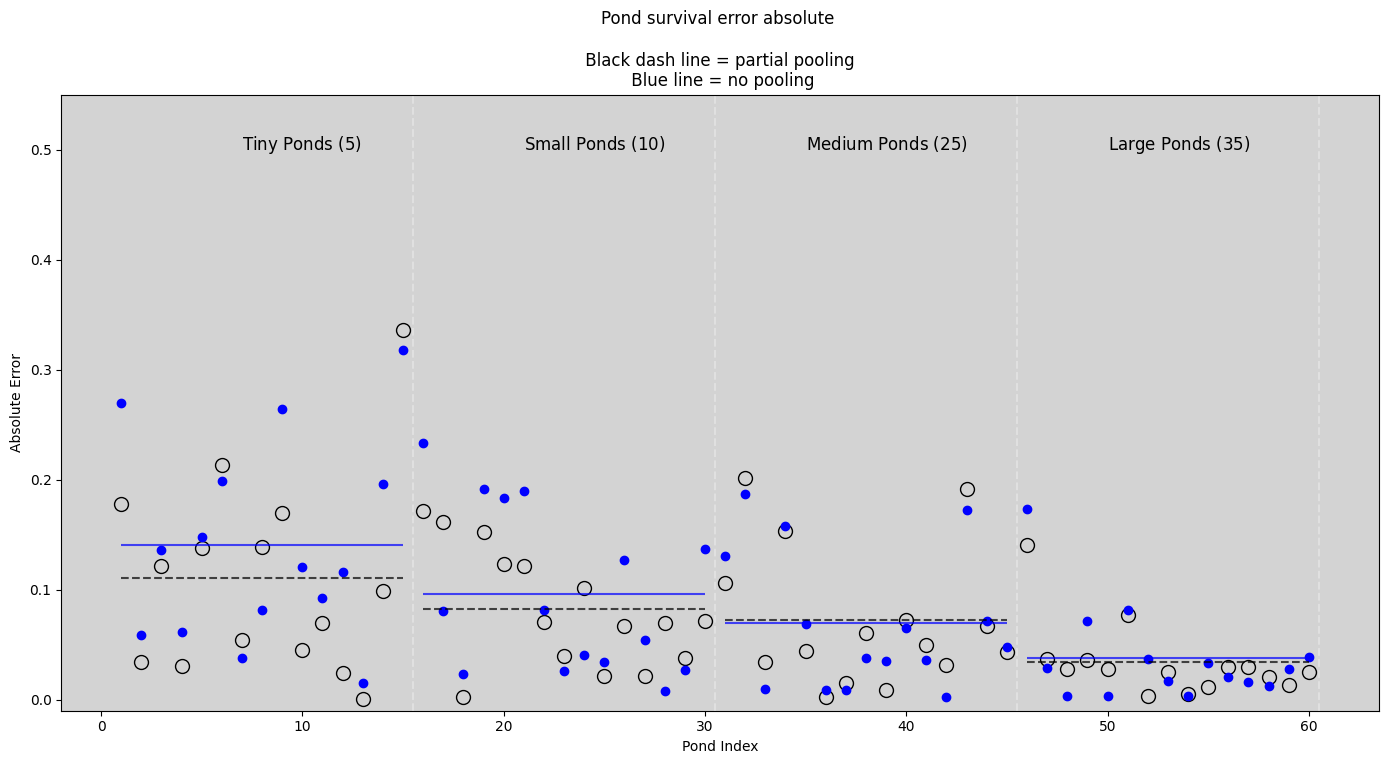

In [138]:
plt.figure(figsize=(17, 8))
plt.ylim = ([0, 1])

plt.scatter(dsim.pond, partpool_error, edgecolors='black', c='lightgray', s=100)
plt.scatter(dsim.pond, no_pool_error, c='blue')

qty_unique_ponds = len(dsim['Ni'].unique())
qty_each_ponds = repeats  # The number of repetitions for each element in each pond.


# Vertical lines
for i in range(qty_unique_ponds):
    plt.axvline(x=qty_each_ponds*(i+1) + 0.5, ls='--', color='white', alpha=0.3)
    
    partpool_error_mean = np.mean(partpool_error[(qty_each_ponds*i):(qty_each_ponds*(i+1))])
    no_pool_error_mean = np.mean(no_pool_error[(qty_each_ponds*i):(qty_each_ponds*(i+1))])
    
    plt.hlines(y=partpool_error_mean, xmin=1+(qty_each_ponds*i), xmax=qty_each_ponds+(qty_each_ponds*i), ls='--', colors='black', alpha=0.7)
    plt.hlines(y=no_pool_error_mean, xmin=1+(qty_each_ponds*i), xmax=qty_each_ponds+(qty_each_ponds*i), ls='-', colors='blue', alpha=0.7)

plt.text(7, 0.5, 'Tiny Ponds ($5$)', size=12)
plt.text(21, 0.5, 'Small Ponds ($10$)', size=12)
plt.text(35, 0.5, 'Medium Ponds ($25$)', size=12)
plt.text(50, 0.5, 'Large Ponds ($35$)', size=12)

plt.gca().set_ylim(-0.01, 0.55)

plt.title('Pond survival error absolute \n\n Black dash line = partial pooling \n Blue line = no pooling')
plt.xlabel('Pond Index')
plt.ylabel('Absolute Error')

plt.show()

### R Code 13.20

In [124]:
# Reuse code in using Rethinking packages in R, here is automatically reuse!
# Just re-run from R Code 13.7

## 13.3 More than one type of cluster

#### Multilevel Chimpanzees

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \gamma_{BLOCK[i]} + \beta_{TREATMENT[i]} $$

$$ \beta_j \sim Normal(0, 0.5) \mbox{  , } j \in \{1, ... ,4\} $$

$$ \alpha_j \sim Normal(\bar{\alpha}, \sigma_\alpha) \mbox{  , } j \in \{1, ... ,7\} $$

$$ \gamma_j \sim Normal(0, \sigma_\gamma) \mbox{  , } j \in \{1, ... ,6\} $$

$$ \bar{\alpha} \sim Normal(0, 1.5) $$

$$ \sigma_{\alpha} \sim Exponential(1) $$

$$ \sigma_{\gamma} \sim Exponential(1) $$

### R Code 13.21

In [142]:
# Previous chimpanzees models is in chapter 11

df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [146]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


In [150]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters {
        
    
    }
    
    model {
    
        pulled_left ~ binomial(1, p);
    }

"""

dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())